# Data Visualization: Ford Go Bike 2017

<ul>
<li><a href="#wrangle">I. Preliminary Wrangling</a></li>
<li><a href="#uni">II. Univariate Exploration</a></li>
<li><a href="#bi">III. Bivariate Exploration</a></li>
<li><a href="#mult">IV. Multivariate Exploration</a></li> 
<li><a href="#next">V. Proposal for the next step</a></li>
<li><a href="#ref">VI. Reference</a></li>    
</ul>

<a id='wrangle'></a>
## I. Preliminary Wrangling  

This document explores a dataset including time, stations, and users' attributes for 519,700 trips.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import calendar
import math
import time

%matplotlib inline

In [3]:
# Import Ford GoBike csv file into jupyter notebook
df = pd.read_csv('2017-fordgobike-tripdata.csv')

### The structure of the dataset  

This dataset includes 519,700 trips with 15 features.  

| Variable Name          | Definition                 |
|------------------------|----------------------------|
| duration_sec           | int64                      |
| start_time             | string                     |
| end_time               | string                     |
| start_station_id       | int64                      |
| start_station_name     | string                     |
| start_station_latitude | float64                    |
| start_station_longitude| float64                    |
| end_station_id         | int64                      |
| end_station_name       | string                     |
| end_station_latitude   | float64                    |
| end_station_longitude  | float64                    |
| bike_id                | int64                      |
| user_type              | string                     |
| member_birth_year      | float64                    |
| member_gender          | string                     |
 
* The time variables in this dataset are all string. They need to be converted to datetime format for the analysis.
* The time variables can be broken down into time of day, day of the week, or month of the year.    
* The dataset provides membership birth year, so ages can be derived by using the year of the dataset, 2017, to divide by the membership birth year.  

### The main feature(s) of interest in the dataset

I am most interested in figuring out when and where are most trips taken because this dataset includes start time/location and end time/location. I focus on the starting points first.   
- Also, I am interested in what are the characteristics (age, sex, and user_type) of the riders and the duration of the trips in these time points and locations.

### The features in the dataset expect to support the investigation into the feature(s) of interest.

I expect the Caltrain or Bart stations in San Francisco will have more trips than other locations because those stations are in the center of the city and connect to other major transportations. Morning and afternoon will have more trips than night time due to rush hours. Also, I assume younger riders are more than older riders because of physical abilities. Moreover, based on the [pricing](https://www.fordgobike.com/pricing), subscribers are more likely riding more than customers. And it's hard to expect female riders are more or males, so I leave this topic in the analysis.

In [4]:
# Find out the structure of the dataset
print(df.shape)
print(df.info())
print(df.head(10))

(519700, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               519700 non-null int64
start_time                 519700 non-null object
end_time                   519700 non-null object
start_station_id           519700 non-null int64
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null int64
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
bike_id                    519700 non-null int64
user_type                  519700 non-null object
member_birth_year          453159 non-null float64
member_gender              453238 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 59.5+ MB
None
   duration_sec                start_time                

In [5]:
# 1. Convert time variables from string to datetime
# a. month of the year
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_month_num'] = df['start_time'].apply(lambda time: time.month)
df['start_month_char'] = df['start_month_num'].apply(lambda x: calendar.month_abbr[x])

In [6]:
 # b. morning, afternoon, night of a day
df['start_hour'] = df['start_time'].apply(lambda time: time.hour)
df['period_day'] = 'morning'
df['period_day'][(df['start_hour'] >= 12) & (df['start_hour'] <= 17)] = 'afternoon'
df['period_day'][(df['start_hour'] >= 18) & (df['start_hour'] <= 23)] = 'night'

/Users/jemchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/jemchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
# Test: time of day
df['period_day'].value_counts()

afternoon    209620
morning      195925
night        114155
Name: period_day, dtype: int64

In [8]:
# c. Day of the week
df['start_weekday_num'] = df['start_time'].apply(lambda time: time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['start_weekday_char'] = df['start_weekday_num'].map(dmap)

In [9]:
# convert time period, month, and weekday into ordered categorical types
ordinal_var_dict = {'start_month_char': ['Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                    'period_day': ['morning', 'afternoon', 'night'],
                    'start_weekday_char': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [10]:
# 2. Create ages
df['age'] = df['member_birth_year'].apply(lambda x: 2017 - x)

<a id='uni'></a>
## II. Univariate Exploration
I start by looking into the start time and start location of this dataset.

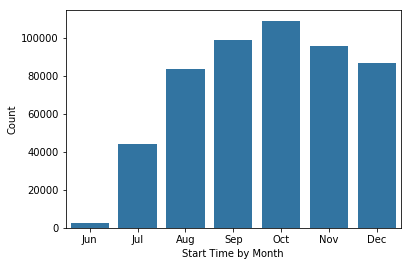

In [11]:
# 1. Time by months 
base_color = sb.color_palette()[0]
sb.countplot(data=df, x='start_month_char', color=base_color)
plt.xlabel('Start Time by Month')
plt.ylabel('Count');

In this time by month figure, why June's trips are way less than other months? I look into each date in this month to figure it out.

In [12]:
df_6 = df.query('start_month_num == 6')
df_6['day'] = df_6['start_time'].apply(lambda x: x.day)
df_6['day'].value_counts()

/Users/jemchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


30    1038
29    1019
28     632
Name: day, dtype: int64

After checking online information (https://en.wikipedia.org/wiki/Ford_GoBike), Ford GoBike was launched since June 28, 2017. There is no data before June 28, 2017, so I decide to remove June data from the analysis.

In [13]:
# remove June's data and save the new dataset as df2
df2 = df.query('start_month_num != 6')

In [14]:
# 2. Location: there are 272 start stations. 
print(len(df2['start_station_name'].value_counts()))
df2['start_station_name'].value_counts()

272


San Francisco Ferry Building (Harry Bridges Plaza)                 14978
The Embarcadero at Sansome St                                      13517
San Francisco Caltrain (Townsend St at 4th St)                     12366
San Francisco Caltrain Station 2  (Townsend St at 4th St)          12003
Market St at 10th St                                               11852
Montgomery St BART Station (Market St at 2nd St)                   11207
Berry St at 4th St                                                 10856
Powell St BART Station (Market St at 4th St)                       10097
Howard St at Beale St                                               9809
Steuart St at Market St                                             9347
Powell St BART Station (Market St at 5th St)                        7910
Embarcadero BART Station (Beale St at Market St)                    7549
2nd St at Townsend St - Coming Soon                                 6487
3rd St at Townsend St                              

There are 272 stations in this dataset. I zoom in to look into Top 8 stations with the most trips that are located in San Francisco.

In [15]:
# Do they have high traffics as end stations? Looks like yes!
print(len(df2['end_station_name'].value_counts()))
df2['end_station_name'].value_counts()

272


San Francisco Caltrain (Townsend St at 4th St)                     17154
San Francisco Ferry Building (Harry Bridges Plaza)                 16856
The Embarcadero at Sansome St                                      16383
San Francisco Caltrain Station 2  (Townsend St at 4th St)          13563
Montgomery St BART Station (Market St at 2nd St)                   13300
Market St at 10th St                                               11223
Powell St BART Station (Market St at 4th St)                       11026
Berry St at 4th St                                                 10512
Steuart St at Market St                                             9321
Powell St BART Station (Market St at 5th St)                        8477
Howard St at Beale St                                               7687
2nd St at Townsend St - Coming Soon                                 7173
Townsend St at 7th St                                               6591
Embarcadero BART Station (Beale St at Market St)   

In [16]:
# Subset the dataset by keeping only top 8 locations with high traffics, df_top8. 
locs = ['San Francisco Ferry Building (Harry Bridges Plaza)','The Embarcadero at Sansome St','San Francisco Caltrain (Townsend St at 4th St)','San Francisco Caltrain Station 2  (Townsend St at 4th St)','Market St at 10th St','Montgomery St BART Station (Market St at 2nd St)','Berry St at 4th St','Powell St BART Station (Market St at 4th St)']
df_top8 = df2.loc[df2['start_station_name'].isin(locs)]
df_top8['start_station_name'].value_counts()


San Francisco Ferry Building (Harry Bridges Plaza)           14978
The Embarcadero at Sansome St                                13517
San Francisco Caltrain (Townsend St at 4th St)               12366
San Francisco Caltrain Station 2  (Townsend St at 4th St)    12003
Market St at 10th St                                         11852
Montgomery St BART Station (Market St at 2nd St)             11207
Berry St at 4th St                                           10856
Powell St BART Station (Market St at 4th St)                 10097
Name: start_station_name, dtype: int64

In [17]:
st_stat_counts = df_top8['start_station_name'].value_counts()
st_stat_order = st_stat_counts.index

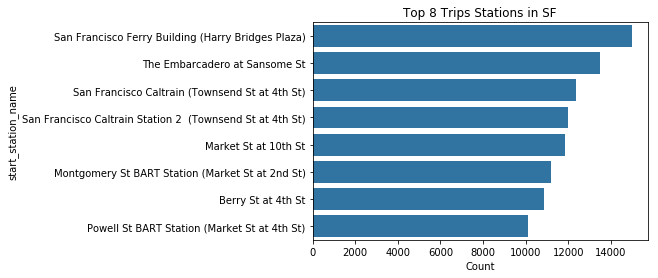

In [238]:
base_color = sb.color_palette()[0]
sb.countplot(data=df_top8, y='start_station_name', color=base_color, order=st_stat_order)
plt.xlabel('Count')
plt.title('Top 8 Trips Stations in SF');

After checking start and end stations, most stations in San Francisco connect to public transportations such as Caltrain, Bart and Ferry. The Embarcadero at Sansome St is very closed to Ferry building and located in financial distrit. Market St at 10th St and Berry St at 4th St are also closed to Bart station. I will look into the time factors in these 8 locations.

In [19]:
# 1.1 Time: month (after subsetting, regenerate the distribution of month again), period of time, weekday
mon_cl = ['Jul','Aug','Sep','Oct','Nov','Dec']
mon_cl2 = pd.api.types.CategoricalDtype(ordered=True, categories=mon_cl)
df_top8['start_month_char'] = df_top8['start_month_char'].astype(mon_cl2)

/Users/jemchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


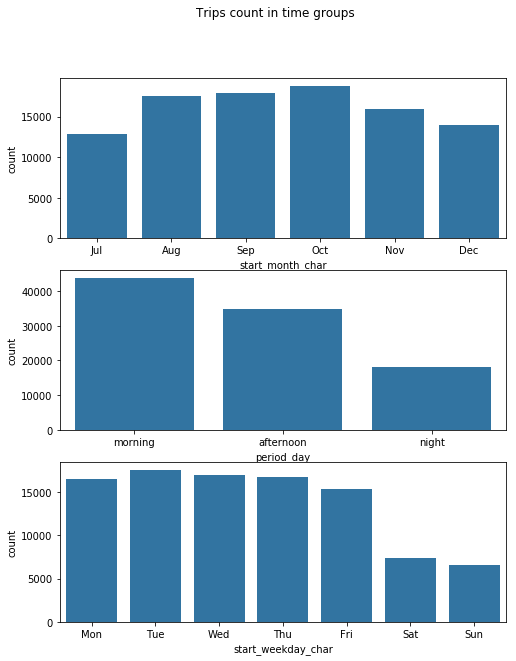

In [237]:
fig, ax = plt.subplots(nrows=3, figsize = [8,10])
default_color = sb.color_palette()[0]
sb.countplot(data = df_top8, x = 'start_month_char', color = default_color, ax = ax[0])
sb.countplot(data = df_top8, x = 'period_day', color = default_color, ax = ax[1])
sb.countplot(data = df_top8, x = 'start_weekday_char', color = default_color, ax = ax[2])
fig.suptitle('Trips\' count in time groups');

In these top 8 trips stations, base on the above figures, I have the following findings:  
1. Besides July, the number of trips gradually decreases when winter is coming. I assume that July's trips are influenced by the launch of the program.   
2. During the day, there are more trips in the morning and afternoon than the night. It probably because of rush hours. Also, the number of trips in the afternoon is less than the morning. I assumed when riders come back home, they might not be back in the afternoon. Probably, they come back during the night so some trips fall into nighttime.  
3. It makes sense that there are more trips during the weekdays and less trips during the weekends because of working schedule.

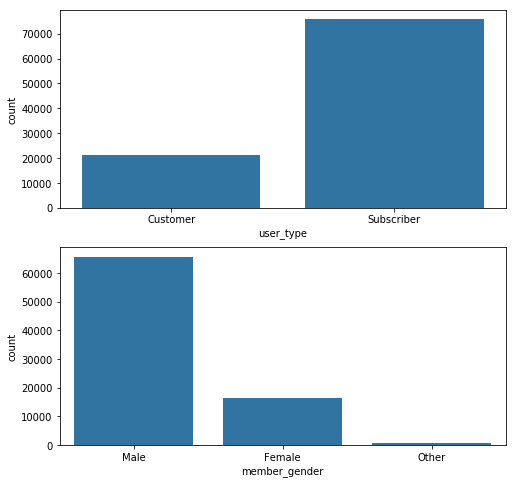

In [21]:
# 3. Rider's characteristics: user type and gender
fig, ax = plt.subplots(nrows=2, figsize = [8,8])
default_color = sb.color_palette()[0]
sb.countplot(data = df_top8, x = 'user_type', color = default_color, ax = ax[0])
sb.countplot(data = df_top8, x = 'member_gender', color = default_color, ax = ax[1]);

In [57]:
df_top8.query('member_gender == "Other"')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,start_month_num,start_month_char,start_hour,period_day,start_weekday_num,start_weekday_char,age
401,1682,2017-12-31 16:42:05.414,2017-12-31 17:10:07.9790,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,70,Central Ave at Fell St,37.773311,...,Subscriber,1968.0,Other,12,Dec,16,afternoon,6,Sun,49.0
683,619,2017-12-31 14:48:05.864,2017-12-31 14:58:25.2500,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,27,Beale St at Harrison St,37.788059,...,Subscriber,1974.0,Other,12,Dec,14,afternoon,6,Sun,43.0
1046,2556,2017-12-31 11:45:27.183,2017-12-31 12:28:03.5950,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,10,Washington St at Kearny St,37.795393,...,Customer,1992.0,Other,12,Dec,11,morning,6,Sun,25.0
1514,1682,2017-12-30 20:33:57.744,2017-12-30 21:02:00.2960,6,The Embarcadero at Sansome St,37.804770,-122.403234,59,S Van Ness Ave at Market St,37.774814,...,Customer,1993.0,Other,12,Dec,20,night,5,Sat,24.0
1599,1375,2017-12-30 18:43:44.406,2017-12-30 19:06:40.1770,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,6,The Embarcadero at Sansome St,37.804770,...,Customer,1993.0,Other,12,Dec,18,night,5,Sat,24.0
1912,2028,2017-12-30 15:22:18.933,2017-12-30 15:56:07.8100,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,70,Central Ave at Fell St,37.773311,...,Subscriber,1968.0,Other,12,Dec,15,afternoon,5,Sat,49.0
2346,509,2017-12-30 13:10:21.960,2017-12-30 13:18:51.4120,6,The Embarcadero at Sansome St,37.804770,-122.403234,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,...,Subscriber,1968.0,Other,12,Dec,13,afternoon,5,Sat,49.0
4336,223,2017-12-29 09:43:37.011,2017-12-29 09:47:20.2330,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,37,2nd St at Folsom St,37.785000,...,Subscriber,1987.0,Other,12,Dec,9,morning,4,Fri,30.0
6229,78,2017-12-28 09:52:08.314,2017-12-28 09:53:26.7980,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,21,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1987.0,Other,12,Dec,9,morning,3,Thu,30.0
6645,956,2017-12-27 21:44:42.113,2017-12-27 22:00:38.1250,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,285,Webster St at O'Farrell St,37.783521,...,Subscriber,1957.0,Other,12,Dec,21,night,2,Wed,60.0


In these top 8 trips stations, base on the above figures, I have the following findings:   
- It makes sense that there are more subscribers than customers. Based on the [pricing page](https://www.fordgobike.com/pricing), monthly membership only takes 15 dollars. For regular customers, one trip takes 2 dollars and one day takes 10 dollars. If riders are commuters or long-term users, it does not make sense for them to choose one time or two time purchases instead of being the members.  
- For the gender groups, the number of trips in male riders is 3 times more than the number of trips in females. Why is that? I will investigate this more in the following.
- There are few riders with 'Other' gender. It's not clear that the riders are not willing to reveal or there are data entry issues.

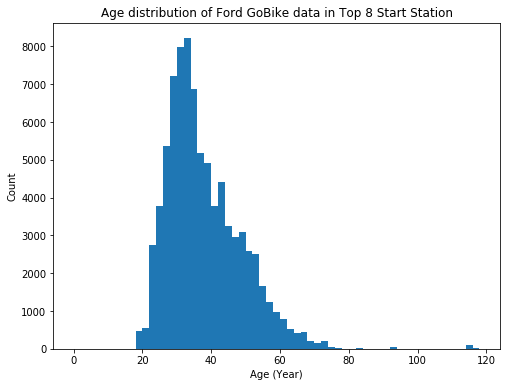

In [22]:
# 4. Age: based on the distribution, we can tell it's right skewed and has some outliers between 100 and 120.
plt.figure(figsize=(8,6))
bins = np.arange(0, df_top8['age'].max()+2, 2)
plt.hist(data=df_top8, x='age', bins=bins)
plt.xlabel('Age (Year)')
plt.ylabel('Count')
plt.title('Age distribution of Ford GoBike data in Top 8 Start Station');

In [63]:
df_top8['age'].describe()

count    82704.000000
mean        37.463206
std         10.857384
min         18.000000
25%         30.000000
50%         35.000000
75%         44.000000
max        117.000000
Name: age, dtype: float64

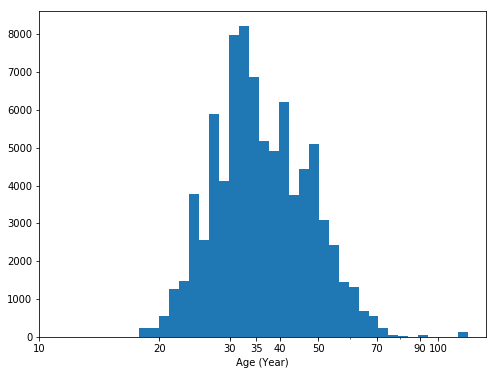

In [53]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10 ** np.arange(1.2, np.log10(df_top8['age'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 6])
plt.hist(data = df_top8, x = 'age', bins = bins)
plt.xscale('log')
plt.xticks([10,20,30,35,40,50,70,90,100], [10,20,30,35,40,50,70,90,100])
plt.xlabel('Age (Year)');

From the figure, most of riders are around 30 years old. Even though there are some riders ages older than 90 years old looks like high outliers, before checking their physical abilities data, I will keep them in the dataset.

In [51]:
df_top8.query('age > 100')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,start_month_num,start_month_char,start_hour,period_day,start_weekday_num,start_weekday_char,age
8077,501,2017-12-27 09:10:01.210,2017-12-27 09:18:22.3530,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,21,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1902.0,Male,12,Dec,9,morning,2,Wed,115.0
16466,559,2017-12-21 09:30:25.835,2017-12-21 09:39:45.5300,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,45,5th St at Howard St,37.781752,...,Subscriber,1902.0,Female,12,Dec,9,morning,3,Thu,115.0
16977,498,2017-12-21 08:12:08.083,2017-12-21 08:20:26.2000,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,21,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1902.0,Male,12,Dec,8,morning,3,Thu,115.0
19981,475,2017-12-20 09:09:33.995,2017-12-20 09:17:29.7450,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,21,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1902.0,Male,12,Dec,9,morning,2,Wed,115.0
20347,535,2017-12-20 08:24:50.744,2017-12-20 08:33:46.2280,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,45,5th St at Howard St,37.781752,...,Subscriber,1902.0,Female,12,Dec,8,morning,2,Wed,115.0
27566,504,2017-12-18 09:13:02.240,2017-12-18 09:21:27.0460,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,21,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1902.0,Male,12,Dec,9,morning,0,Mon,115.0
35111,471,2017-12-15 09:34:52.612,2017-12-15 09:42:44.1540,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,45,5th St at Howard St,37.781752,...,Subscriber,1902.0,Female,12,Dec,9,morning,4,Fri,115.0
35723,512,2017-12-15 08:24:09.992,2017-12-15 08:32:42.5570,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,21,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1902.0,Male,12,Dec,8,morning,4,Fri,115.0
39292,928,2017-12-14 09:13:35.492,2017-12-14 09:29:03.6310,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,3,Powell St BART Station (Market St at 4th St),37.786375,...,Subscriber,1902.0,Female,12,Dec,9,morning,3,Thu,115.0
39757,356,2017-12-14 08:40:51.218,2017-12-14 08:46:48.0280,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,48,2nd St at S Park St,37.782411,...,Subscriber,1911.0,Other,12,Dec,8,morning,3,Thu,106.0


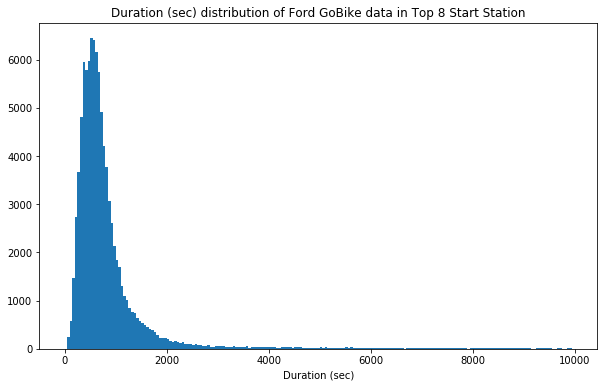

In [54]:
# 5. duration of trips
plt.figure(figsize=(10,6))
#bins = np.arange(0, df_top8_le100['duration_sec'].max()+50, 100)
bins = np.arange(0, 10000, 50)
plt.hist(data=df_top8, x='duration_sec', bins=bins)
plt.xlabel('Duration (sec)')
plt.title('Duration (sec) distribution of Ford GoBike data in Top 8 Start Station');

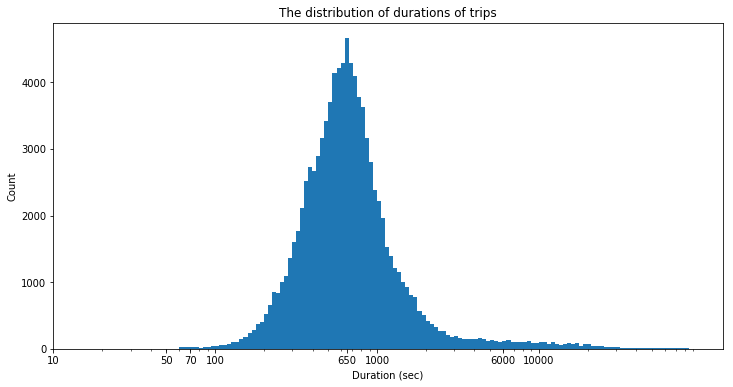

In [240]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10 ** np.arange(1.2, np.log10(df_top8['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[12, 6])
plt.hist(data = df_top8, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([10,50,70,100,650,1000,6000,10000], [10,50,70,100,650,1000,6000,10000])
plt.xlabel('Duration (sec)')
plt.ylabel('Count')
plt.title('The distribution of durations of trips');

From the figure, most durations of trips fall into 650 seconds (10.8 minutes).

In [56]:
# Only use the subsetted dataset to perform the rest of analysis.
df_top8.to_csv("2017-fordgobike-tripdata-clean.csv", index=False)

### Transformations  
The variables, age and duration_sec, look like right skewed, so I look into these two variables using a log transform. Under the transformations, age's data has one big peak between 30 and 40 years old and some small peak. Duration's data looks like unimodel with one peak between 550 and 650 seconds.

### Data Cleaning  
1. June's data is way less than the other months. After I look into it and find that the program launched on June 28th, so there are only three days data in this month. Therefore, I remove June from the analysis.
2. I am most interested in the most traffic locations. After looking into trips count in each station, I pick top 8 stations over 10,000 trips.  

San Francisco Ferry Building (Harry Bridges Plaza)  
The Embarcadero at Sansome St  
San Francisco Caltrain (Townsend St at 4th St)  
San Francisco Caltrain Station 2  (Townsend St at 4th St)  
Market St at 10th St  
Montgomery St BART Station (Market St at 2nd St)   
Berry St at 4th St   
Powell St BART Station (Market St at 4th St)   

3. For the age distribution, there are few riders older than 90. They look like outliers. However, before I acquire their physical abilities' data, I think it is fair enough to keep them in the dataset.

4. For the gender groups, there is a 'Other' category. Before I confirm the information, I will keep them in the dataset.

<a id='bi'></a>
## III. Bivariate Exploration

In [133]:
# Prepare lists of numeric variables and categorical variables
numeric_vars = ['age','duration_sec']
times_chr = ['period_day','start_weekday_char','start_month_char']
users_chr = ['user_type','member_gender']

In [142]:
# Order top 8 stations from the number one (most trips) to the number eight (least trips)
loc_cl = locs = ['San Francisco Ferry Building (Harry Bridges Plaza)','The Embarcadero at Sansome St','San Francisco Caltrain (Townsend St at 4th St)','San Francisco Caltrain Station 2  (Townsend St at 4th St)','Market St at 10th St','Montgomery St BART Station (Market St at 2nd St)','Berry St at 4th St','Powell St BART Station (Market St at 4th St)']
loc_cl2 = pd.api.types.CategoricalDtype(ordered=True, categories=loc_cl)
df_top8['start_station_name'] = df_top8['start_station_name'].astype(loc_cl2)

/Users/jemchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


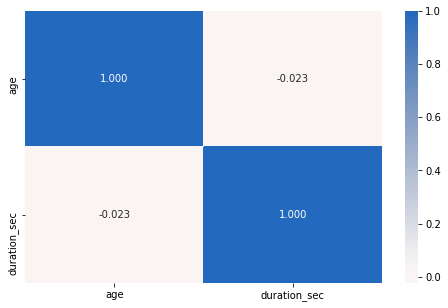

In [61]:
# 1. Numeric variables: correlation between age and duration second
plt.figure(figsize = [8, 5])
sb.heatmap(df_top8[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0);

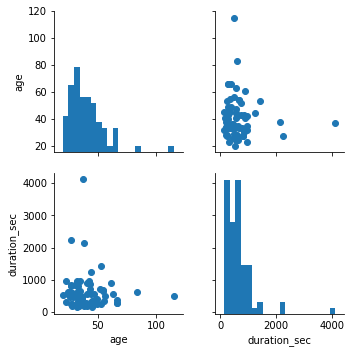

In [169]:
# plot matrix for age and duration: sample 500 so that plots are clearer. 
samples = np.random.choice(df_top8.shape[0], 500, replace = False)
df_top8_samp = df_top8.loc[samples,:]

g = sb.PairGrid(data = df_top8_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(plt.scatter);

Based on the correlation, age is low and negative correlated with duration against of my assumption (age and duration is negatively correlated). However, it actually make sense that in this dataset, the major population of age is between 30 and 40 years old. We have less samples in the older population. 

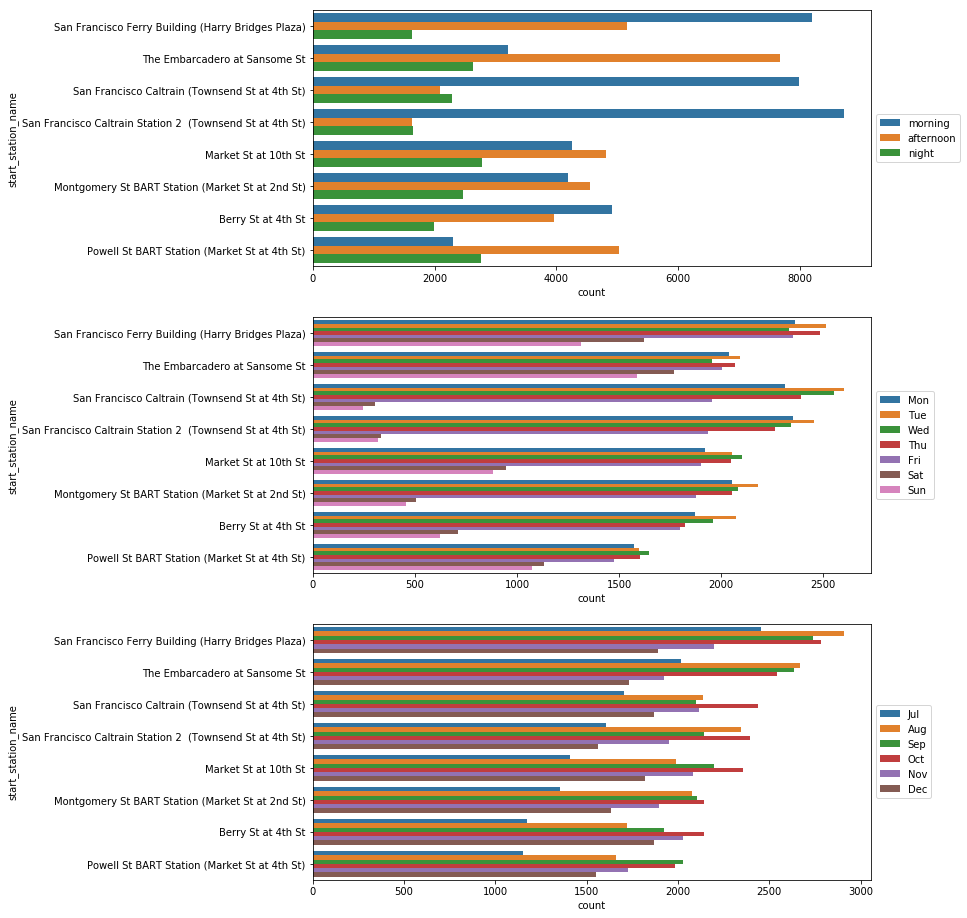

In [143]:
# 2. Categorical variables: top 8 stations by times (period of day, weekdays, months)
fig = plt.figure(figsize=(10,16))
for i in range(1, 4):
    ax = fig.add_subplot(3, 1, i)
    sb.countplot(data=df_top8, y='start_station_name', hue=times_chr[i-1])
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5));

After breaking down into each station,  
1. Time of day: morning is not necessary the period of time with most trips. Half of stations have the most trips during the morning and another half of stations has the most trips during the afternoon. It needs to be investigated more.  
2. Day of week: weekdays (Monday, Tuesday, Wednesday, Thursday and Friday) have the most trips than weekends. Compared to other weekdays, Friday has less trips. I think that some people work from home on Friday like me ;p. Some stations' weekends have more trips than other stations (even their trips are still less than weekdays') might because these stations are close to tourist attractions. But all of points need to be taken a deeper look.  
3. Besides July (the program just launched), from August to October, the number of trips gradually increases and it decreases in the winder (November and December). Biking might be correlated with the weather. It needs more weather forecast data to support the assumption.

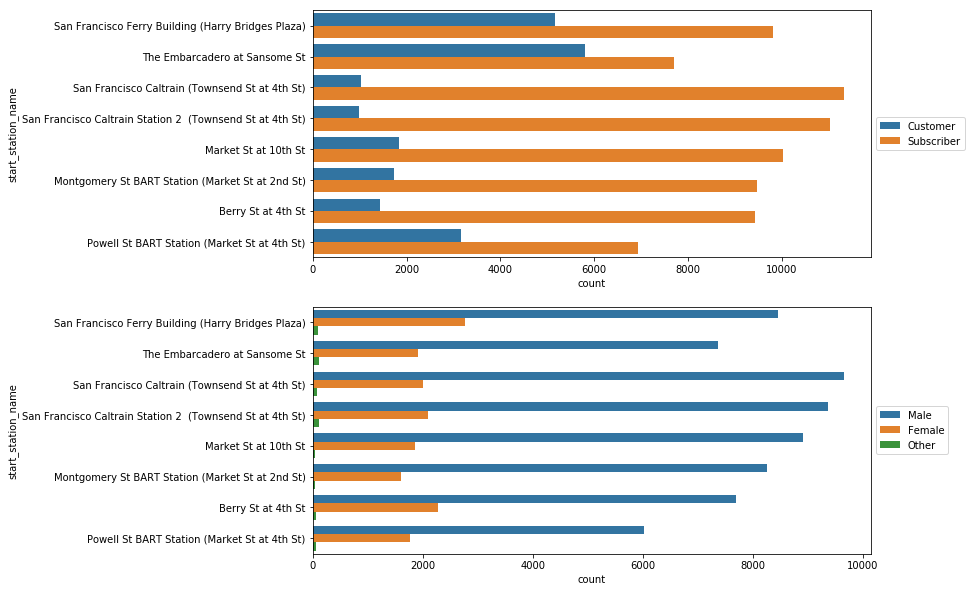

In [144]:
# 3. Categorical variables: top 8 stations by users' attributes (user_type, member's gender)
fig = plt.figure(figsize=(10,10))
for i in range(1, 3):
    ax = fig.add_subplot(2, 1, i)
    sb.countplot(data=df_top8, y='start_station_name', hue=users_chr[i-1])
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5));

After breaking down into top 8 station by users' attributes:   
1. Apparently, subscribers are more than customers in each station. However, there are more customers at San Francisco Ferry Building (Harry Bridges Plaza) and The Embarcadero at Sansome St stations than at other stations. Customers might include tourists.
2. The trips in male riders are way more than in females. Even though I look into the [gender distribution in SF](https://www.states101.com/gender-ratios/california/san-francisco-county). It cannot explain why males riders are more. It needs to be investigated deeper.

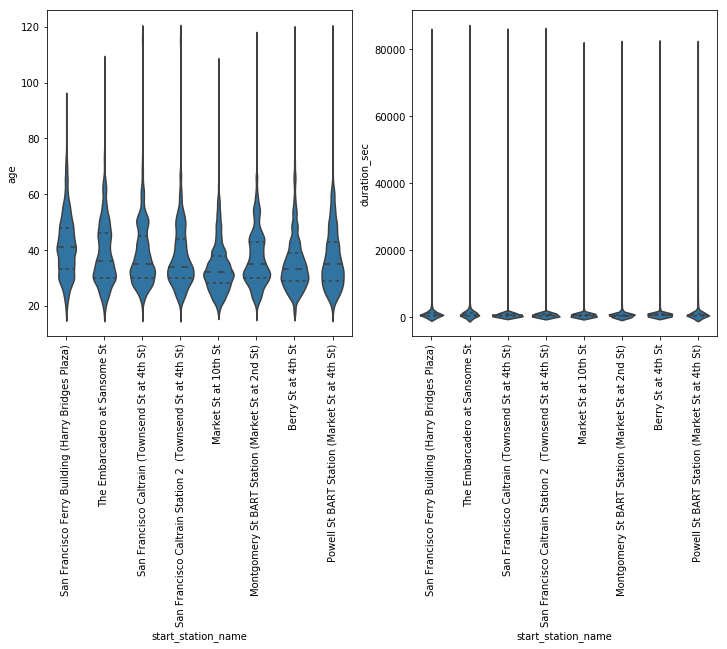

In [147]:
# 4. Numeric variables: Top 8 stations by age, Top 8 stations by duration of trips
plt.figure(figsize=(12,6))
base_color = sb.color_palette()[0]
ax = plt.subplot(121)
sb.violinplot(data=df_top8, x='start_station_name', y='age', inner='quartile', color=base_color)
plt.xticks(rotation=90)

ax = plt.subplot(122)
sb.violinplot(data=df_top8, x='start_station_name', y='duration_sec', inner='quartile',color=base_color)
plt.xticks(rotation=90);

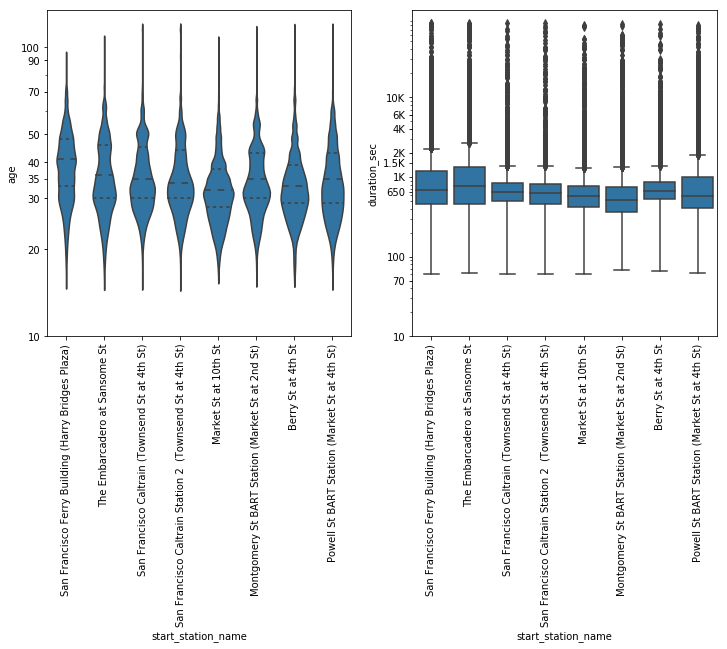

In [172]:
plt.figure(figsize=(12,6))
base_color = sb.color_palette()[0]
ax = plt.subplot(121)
sb.violinplot(data=df_top8, x='start_station_name', y='age', inner='quartile', color=base_color)
plt.xticks(rotation=90)
plt.yscale('log')
plt.yticks([10,20,30,35,40,50,70,90,100], [10,20,30,35,40,50,70,90,100])

ax = plt.subplot(122)
sb.boxplot(data=df_top8, x='start_station_name', y='duration_sec',color=base_color)
plt.xticks(rotation=90)
plt.yscale('log')
plt.yticks([10,50,100,650,1000,1500,2000,4000,6000,10000], [10,70,100,650,'1K','1.5K','2K','4K','6K','10K']);

In [176]:
len(df_top8.query('duration_sec > 1500')['duration_sec'])/len(df_top8['duration_sec'])

0.09995251661918328

After log-transformed, most of median age population (between 30 to 40) is consistent in each station. The median of duration (second) falls around 650 second. However, after 1500 second, there are a lot of high outliers around 9.9%. 

### Observed relationships in bivariate exploration.
In the top 8 stations, look into the attributes' times and users:  
1. Time:   


- After separating into eight stations, morning is not necessary the one with most trips. But half of stations has the most trips in the morning and another half of stations has the most trips in the afternoon. 
- There are more trips during the weekdays than in weekends. However, in customers, some stations like San Francisco Ferry Building (Harry Bridges Plaza) and The Embarcadero at Sansome St stations have more trips than others in the weekend. Will tourist attractions be another feature causing more trips? Also, compared to other weekdays, Friday has slightly less than trips. I am guessing probably more people work from home that day instead of being in the office like me ;p.  
- Besides July (The program just launched.), before the winder, the number of trips has been gradually increased. After the winder, the number of trips has been gradually decreased. Thus, it implies that weather is one of key features.   


2. User:


- Age: most of age population falls between 30 and 40 years old. It might imply there are full time employees and commuters.
- Gender: the number of trips in males is way more than the number in females. It needs to be investigated more.
- Subscribe: the number of trips in subscribers is more than the number in customers because of pricing and population.



### Any interesting relationships between the other features  
Age and duration of trips are slightly negative-correlated. Majority of age population locates between 30 and 40 years old, so it is probably the reason that other age groups are not observed.

<a id='mult'></a>
## IV. Multivariate Exploration
I am most interested in locations and time with most trips. Now on, I would like to see how the trends differ after adding third or more variables.

In [181]:
# (1) Top 8 trip stations by times in each user type
df_cust = df_top8.query('user_type == "Customer"')

In [182]:
df_sub = df_top8.query('user_type == "Subscriber"')

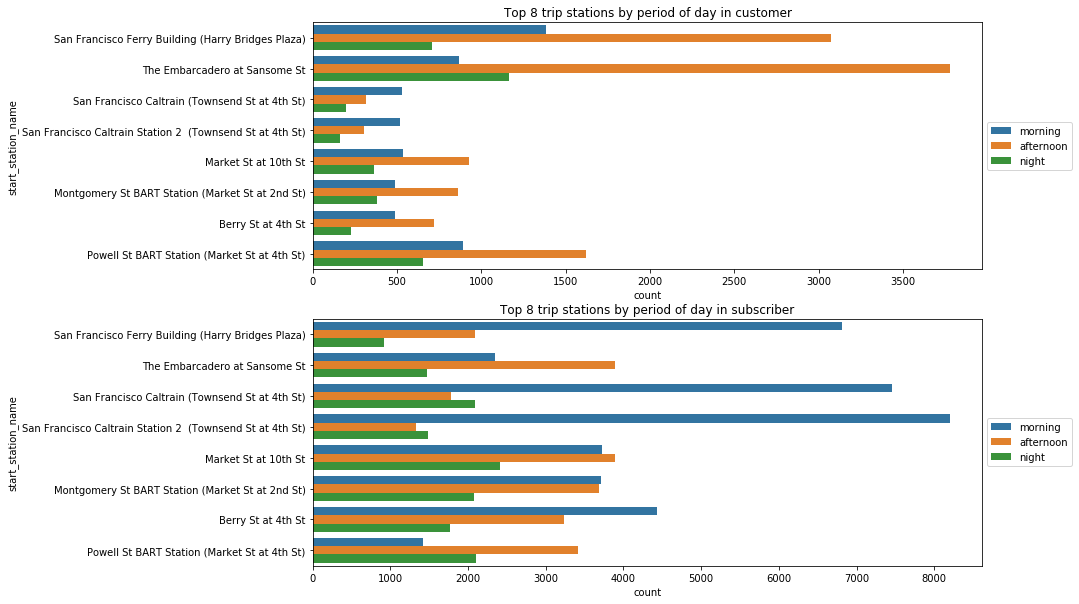

In [185]:
# 1. period of day: morning, afternoon, night
plt.figure(figsize=(12,10))
ax = plt.subplot(211)
sb.countplot(data=df_cust, y='start_station_name', hue='period_day')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by period of day in customer')

ax = plt.subplot(212)
sb.countplot(data=df_sub, y='start_station_name', hue='period_day')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by period of day in subscriber');

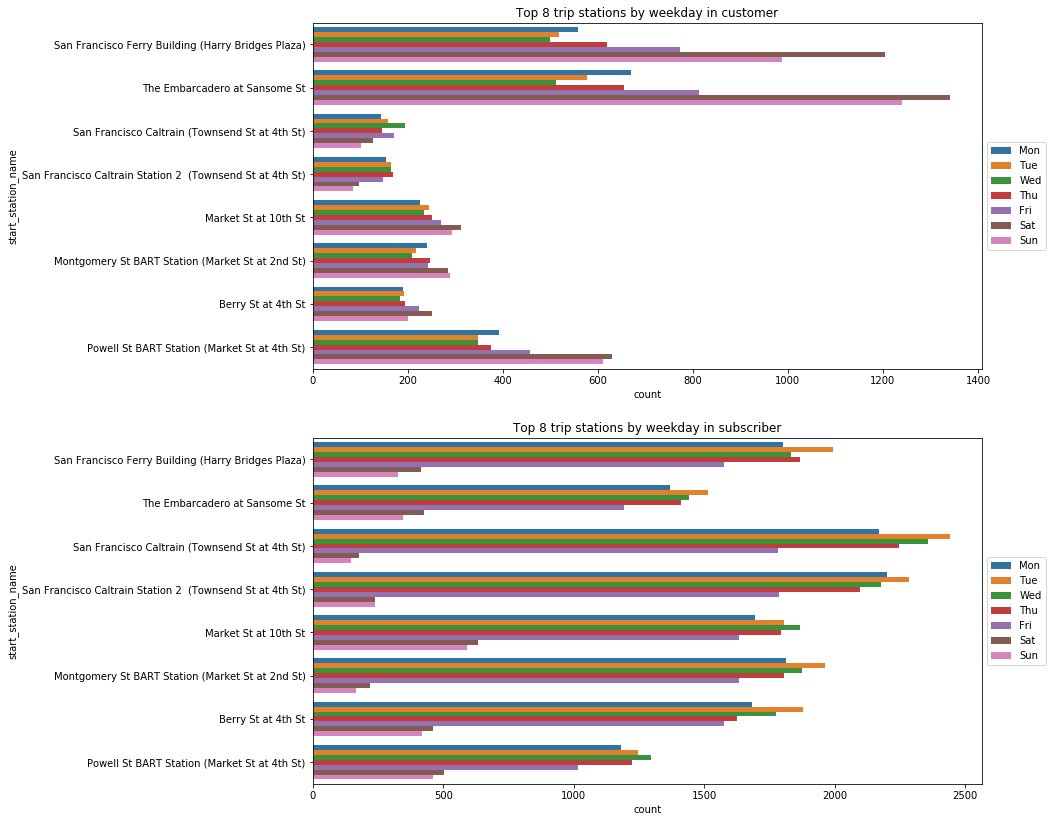

In [190]:
# 2. Weekday
plt.figure(figsize=(12,14))
ax = plt.subplot(211)
sb.countplot(data=df_cust, y='start_station_name', hue='start_weekday_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by weekdays in customer')

ax = plt.subplot(212)
sb.countplot(data=df_sub, y='start_station_name', hue='start_weekday_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by weekdays in subscriber');

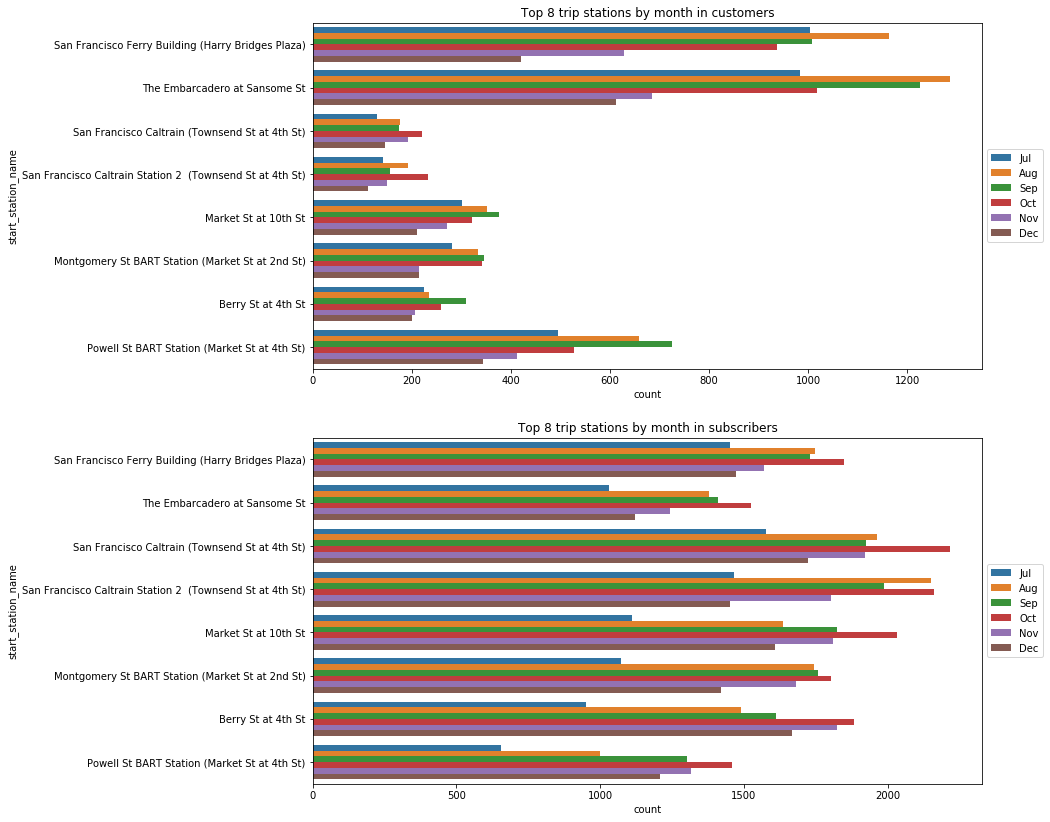

In [195]:
# 3. Month
plt.figure(figsize=(12,14))
ax = plt.subplot(211)
sb.countplot(data=df_cust, y='start_station_name', hue='start_month_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by months in customers')

ax = plt.subplot(212)
sb.countplot(data=df_sub, y='start_station_name', hue='start_month_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by months in subscribers');

After separating customers from subscribers, there are some very interesting findings in these 3 time categorical variables.   
1. Period of time per day: there are more trips in the morning or afternoon no matter in customers or subscribers.  
2. Weekdays: it implies customers probably includes tourists because most trips happen in the weekend. On the other hand, subscribers imply commuters because most trips happen in the weekdays.  
3. Months: in the customers' trips, there are more trips in ferry building and Embarcadero, especially in August. There are two main tourist attractions. In the subscribers' trips, the stations are close to Bart and Caltrain stations have more trips than tourist attractions. In subscribers, after launching, trips gradually increase and then decrease when the weather becomes colder.  

In [194]:
df_f = df_top8.query('member_gender == "Female"')
df_m = df_top8.query('member_gender == "Male"')

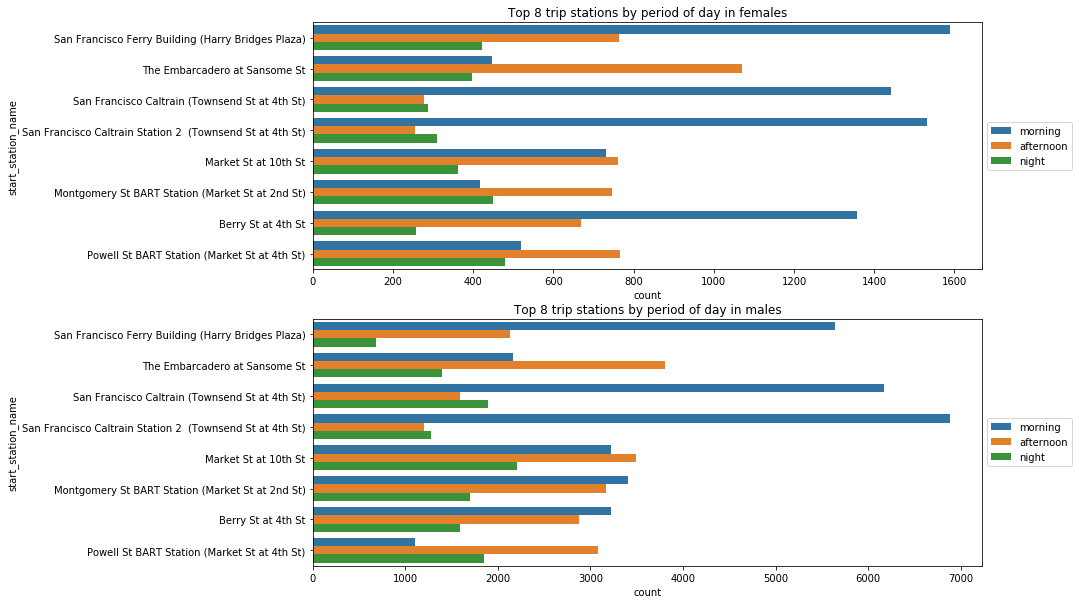

In [196]:
# (2) Top 8 trip stations by times in each gender
# 1. period of day
plt.figure(figsize=(12,10))
ax = plt.subplot(211)
sb.countplot(data=df_f, y='start_station_name', hue='period_day')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by period of day in females')

ax = plt.subplot(212)
sb.countplot(data=df_m, y='start_station_name', hue='period_day')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by period of day in males');

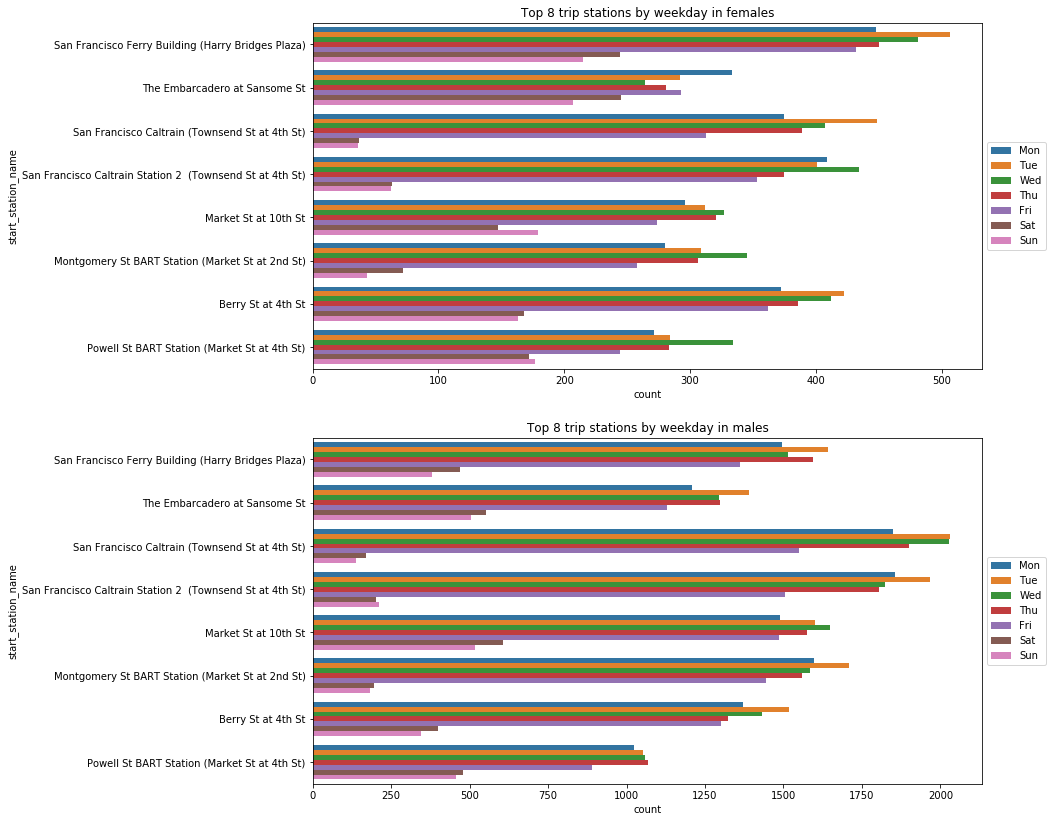

In [197]:
# 2. Weekday
plt.figure(figsize=(12,14))
ax = plt.subplot(211)
sb.countplot(data=df_f, y='start_station_name', hue='start_weekday_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by weekday in females')

ax = plt.subplot(212)
sb.countplot(data=df_m, y='start_station_name', hue='start_weekday_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by weekday in males');

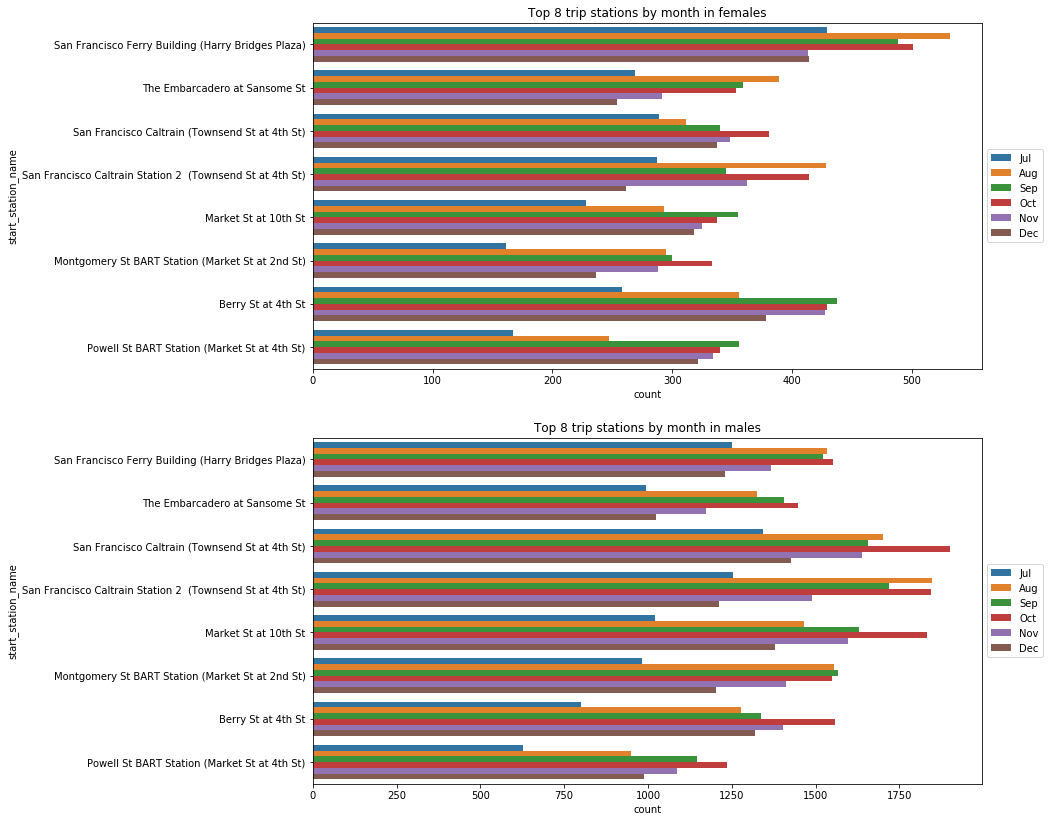

In [198]:
# 3. Month
plt.figure(figsize=(12,14))
ax = plt.subplot(211)
sb.countplot(data=df_f, y='start_station_name', hue='start_month_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by month in females')

ax = plt.subplot(212)
sb.countplot(data=df_m, y='start_station_name', hue='start_month_char')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Top 8 trip stations by month in males');

Between females and males, the trends in time of day, weekdays, and months look very similar.

In [205]:
# Station names are a little bit too long. Use station id instead.
df_top8.groupby('start_station_name')['start_station_id'].value_counts()

start_station_name                                         start_station_id
San Francisco Ferry Building (Harry Bridges Plaza)         15                  14978
The Embarcadero at Sansome St                              6                   13517
San Francisco Caltrain (Townsend St at 4th St)             30                  12366
San Francisco Caltrain Station 2  (Townsend St at 4th St)  67                  12003
Market St at 10th St                                       58                  11852
Montgomery St BART Station (Market St at 2nd St)           21                  11207
Berry St at 4th St                                         81                  10856
Powell St BART Station (Market St at 4th St)               3                   10097
Name: start_station_id, dtype: int64

<Figure size 720x1152 with 0 Axes>

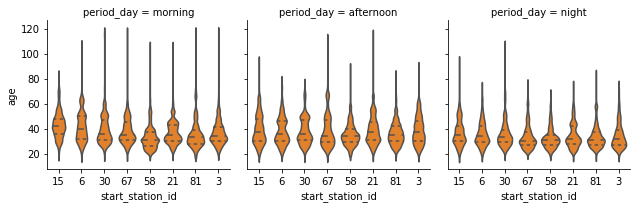

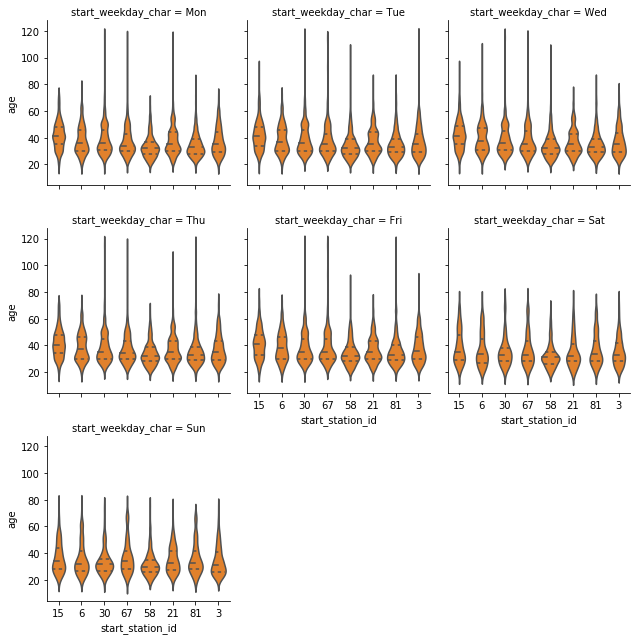

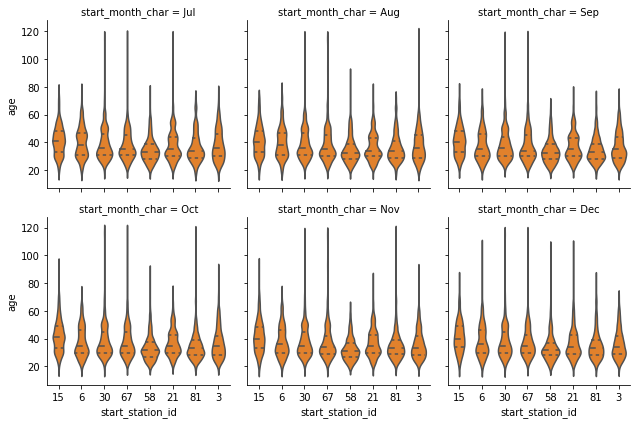

In [223]:
# (3) Top 8 trips station by times (period of day, weekdays, months) in age distribution
fig = plt.figure(figsize=(10,16))
base_color = sb.color_palette()[1]
for i in range(1, 4):
    g = sb.FacetGrid(data=df_top8, col=times_chr[i-1], col_wrap=3)
    g.map(sb.violinplot,'start_station_id', 'age', inner='quartile', order=[15,6,30,67,58,21,81,3], color=base_color);

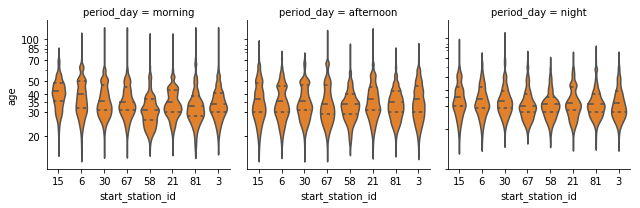

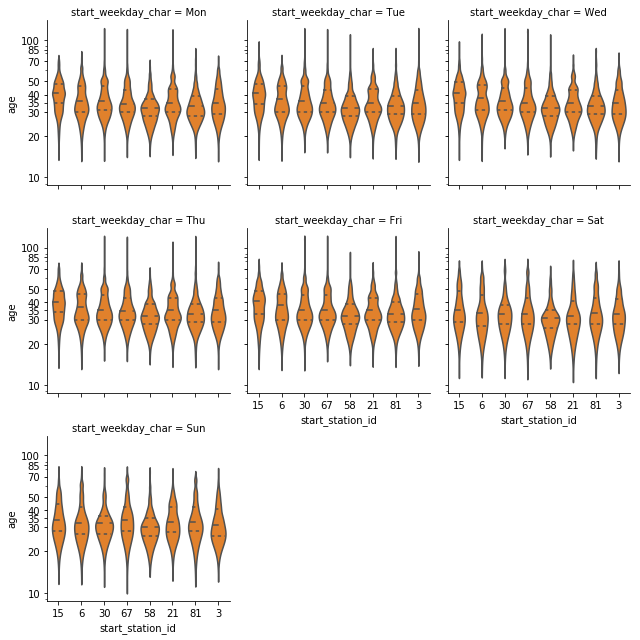

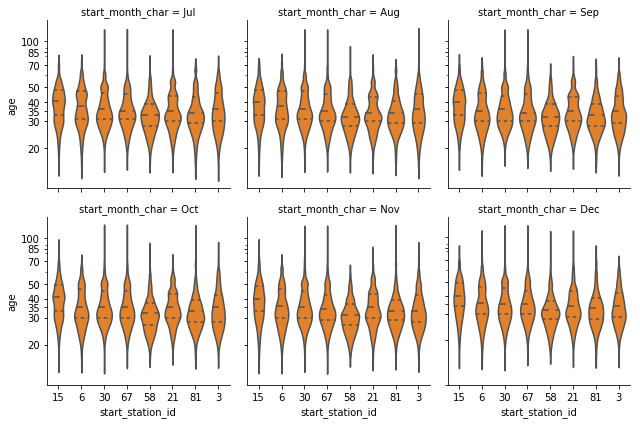

In [224]:
# (3) Top 8 trips station by times (period of day, weekdays, months) in log-transformed age distribution
base_color = sb.color_palette()[1]
for i in range(1, 4):
    g = sb.FacetGrid(data=df_top8, col=times_chr[i-1], col_wrap=3)
    g.map(sb.violinplot,'start_station_id', 'age', inner='quartile', order=[15,6,30,67,58,21,81,3], color=base_color)
    plt.yscale('log')
    plt.yticks([10,20,30,35,40,50,70,85,100], [10,20,30,35,40,50,70,85,100]);

In the age distribution, there are not big different in time and locations. Most medians fall between 30 and 40 years old.

<Figure size 720x1152 with 0 Axes>

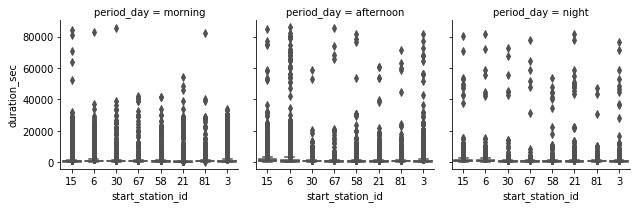

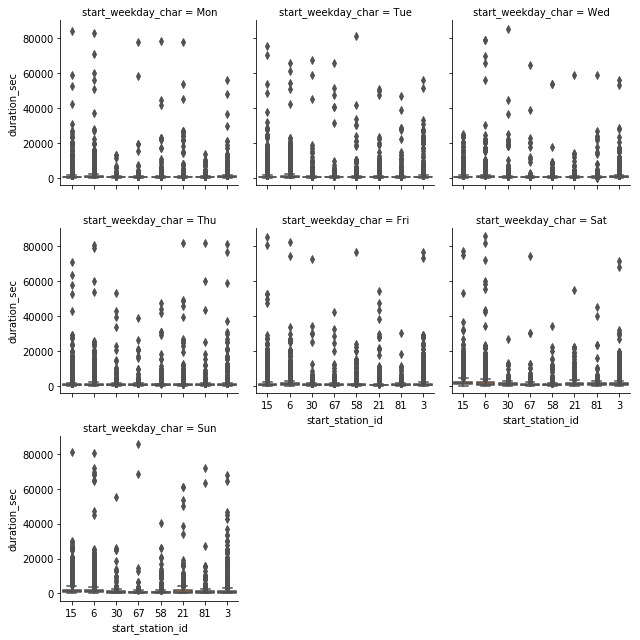

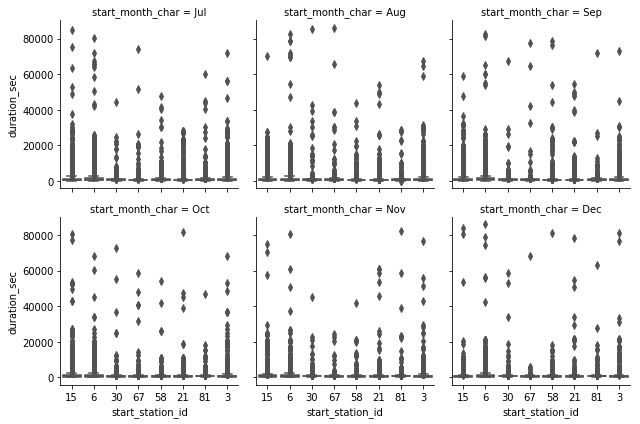

In [226]:
# (4) Top 8 trips station by times (period of day, weekdays, months) in duration of trips distribution
fig = plt.figure(figsize=(10,16))
base_color = sb.color_palette()[1]
for i in range(1, 4):
    g = sb.FacetGrid(data=df_top8, col=times_chr[i-1], col_wrap=3)
    g.map(sb.boxplot,'start_station_id', 'duration_sec', order=[15,6,30,67,58,21,81,3], color=base_color);

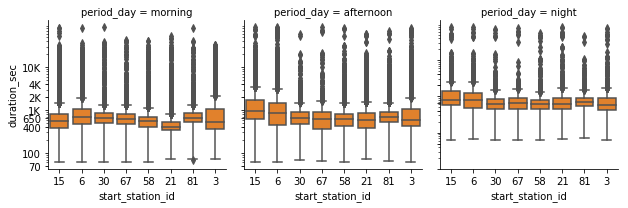

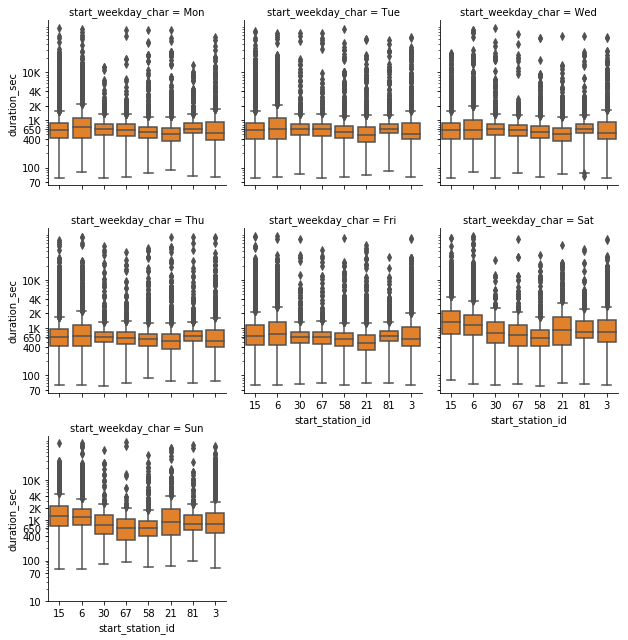

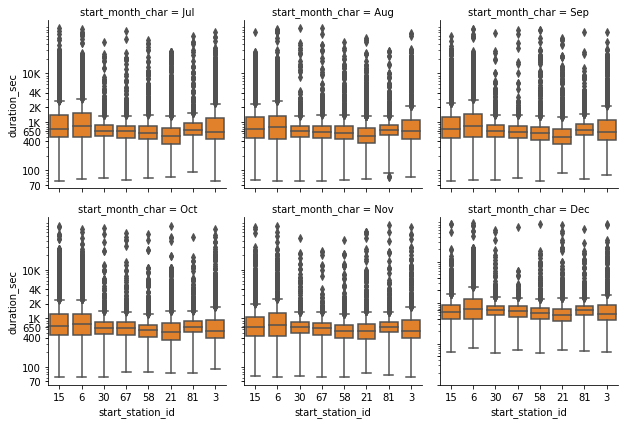

In [231]:
# (4) Top 8 trips station by times (period of day, weekdays, months) in log-transformed duration of trips distribution
base_color = sb.color_palette()[1]
for i in range(1, 4):
    g = sb.FacetGrid(data=df_top8, col=times_chr[i-1], col_wrap=3)
    g.map(sb.boxplot,'start_station_id', 'duration_sec', order=[15,6,30,67,58,21,81,3], color=base_color)
    plt.yscale('log')
    plt.yticks([10,50,100,400,650,1000,2000,4000,10000], [10,70,100,400,650,'1K','2K','4K','10K']);

After log transformed, the trips are longer at night, on Saturday and on Sunday, in December. I am interested in if user types impact the duration of trips too.

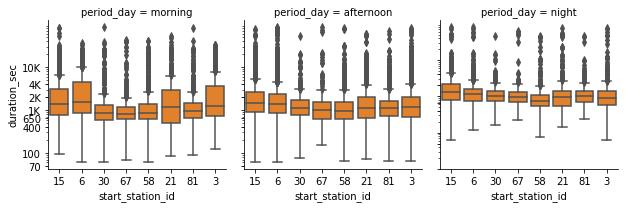

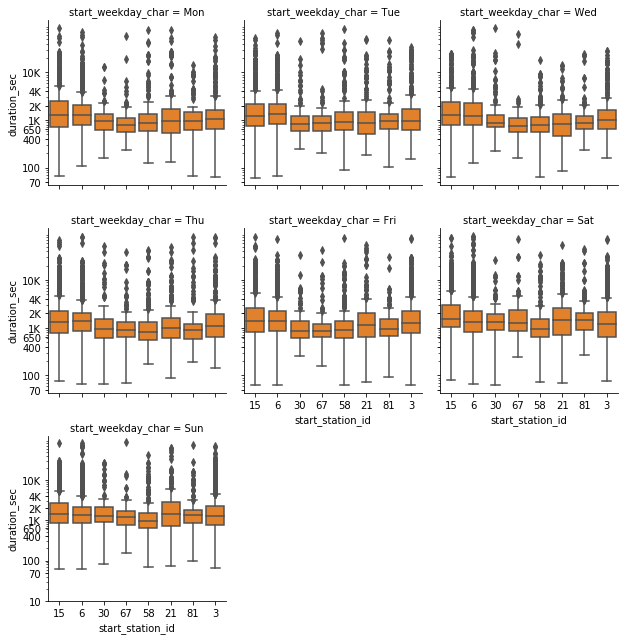

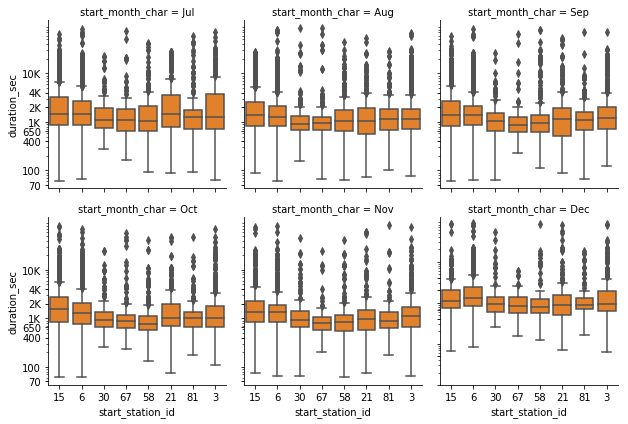

In [232]:
# (4) Top 8 trips station by times (period of day, weekdays, months) in log-transformed duration of trips distribution and in customers
base_color = sb.color_palette()[1]
for i in range(1, 4):
    g = sb.FacetGrid(data=df_cust, col=times_chr[i-1], col_wrap=3)
    g.map(sb.boxplot,'start_station_id', 'duration_sec', order=[15,6,30,67,58,21,81,3], color=base_color)
    plt.yscale('log')
    plt.yticks([10,50,100,400,650,1000,2000,4000,10000], [10,70,100,400,650,'1K','2K','4K','10K']);

After separating subscribers from customers, the median of duration of trips in customers is between 1000 and 2000 seconds. The trips at night and in December are longer. It makes sense that December's trips are longer because of holiday season. However, the trips at night need to be investigated deeper.

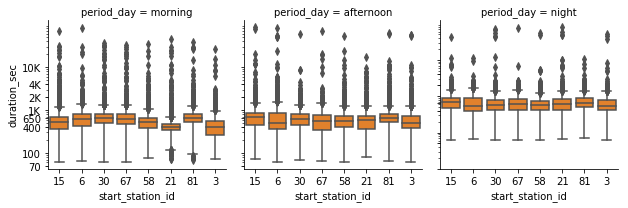

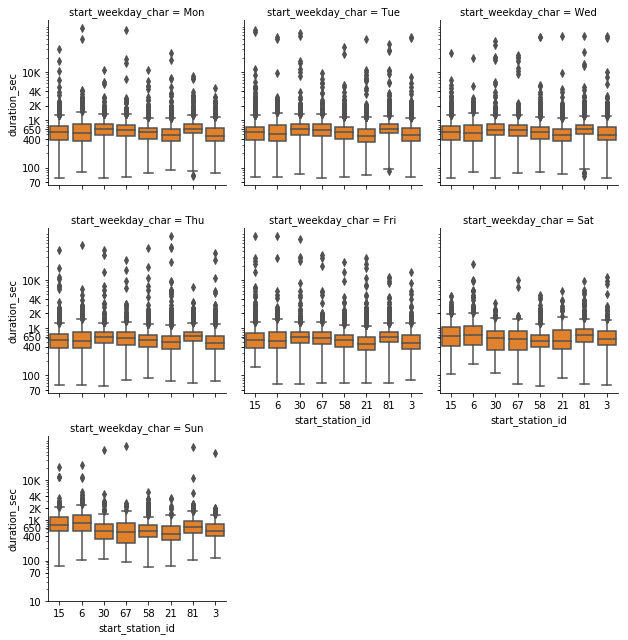

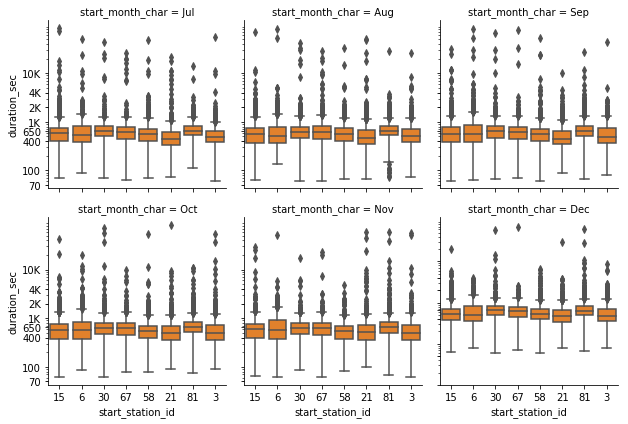

In [233]:
# (4) Top 8 trips station by times (period of day, weekdays, months) in log-transformed duration of trips distribution and in subscribers
base_color = sb.color_palette()[1]
for i in range(1, 4):
    g = sb.FacetGrid(data=df_sub, col=times_chr[i-1], col_wrap=3)
    g.map(sb.boxplot,'start_station_id', 'duration_sec', order=[15,6,30,67,58,21,81,3], color=base_color)
    plt.yscale('log')
    plt.yticks([10,50,100,400,650,1000,2000,4000,10000], [10,70,100,400,650,'1K','2K','4K','10K']);

After separating customers from subscribers, the median of duration of trips falls between 650 and 1000 seconds. The duration of trips are longer at night and in December. It also make sense that December's trips are longer because of holiday season. However, the trips at night need to be investigated more.

### Features strengthen each other in terms of looking at locations and times
Separating user types, customers and subscribers, displays more information from location and time. Customers might be tourists who like to ride a bike during the weekend and in the summer. Also, the number of trips increases in the tourist attractions like Ferry building and Embarcadero (close to piers). On the other hand, subscribers might be commuters. The trips in subscribers increase during the weekdays and after launching, the number of trips gradually increases and then decreases when the weather becomes colder.

### Interesting or surprising interactions between features
Based on the user types, the figures show us the significant trends. It also impacts the duration of trips. The median of duration of trips in customers (1000-2000 seconds) are longer than in subscribers (650 seconds). The trips in December are longer than other months both in customers and subscribers. I assumed because of holiday season.


<a id='next'></a>
## V. Proposal for the next step  
1. It is hard to tell the difference between females and males. It need to be investigated more with new features.  
2. The duration of trips at night is longer than other time of day. It needs to be investigated deeper with new features.

<a id='ref'></a>
## VI. Reference
1. Dataset,2017-fordgobike-tripdata.csv, https://s3.amazonaws.com/fordgobike-data/index.html
2. license https://assets.fordgobike.com/data-license-agreement.html